In [13]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
from load_data import get_historical_forecast_pandas, get_historical

import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt

from load_data import get_region_geojson

# How many regions are there?

In [4]:
us_regions = pd.read_csv("../../../optimizer/us_region_meta_data.csv",index_col=0)
print(us_regions["region_name"].nunique())

88


In [5]:
us_regions.region.unique()

array(['AECI', 'AVA', 'AZPS', 'BANC', 'BPA', 'CAISO_ESCONDIDO',
       'CAISO_LONGBEACH', 'CAISO_NORTH', 'CAISO_PALMSPRINGS',
       'CAISO_REDDING', 'CAISO_SANBERNARDINO', 'CAISO_SANDIEGO', 'CHPD',
       'CPLE', 'CPLW', 'DOPD', 'DUK', 'ELE', 'ERCOT_AUSTIN',
       'ERCOT_COAST', 'ERCOT_EASTTX', 'ERCOT_HIDALGO',
       'ERCOT_NORTHCENTRAL', 'ERCOT_PANHANDLE', 'ERCOT_SANANTONIO',
       'ERCOT_SECOAST', 'ERCOT_SOUTHTX', 'ERCOT_WESTTX', 'FMPP', 'FPC',
       'FPL', 'GVL', 'IID', 'IPCO', 'ISONE_CT', 'ISONE_ME', 'ISONE_NEMA',
       'ISONE_NH', 'ISONE_RI', 'ISONE_SEMA', 'ISONE_VT', 'ISONE_WCMA',
       'JEA', 'LDWP', 'LGEE', 'MISO_INDIANAPOLIS', 'MISO_N_DAKOTA',
       'MPCO', 'NEVP', 'NYISO_NYC', 'PACE', 'PACW', 'PGE',
       'PJM_EASTERN_KY', 'PJM_EASTERN_OH', 'PJM_NJ', 'PJM_SOUTHWEST_OH',
       'PJM_WESTERN_KY', 'PNM', 'PSCO', 'PSEI', 'SC', 'SCEG', 'SCL',
       'SEC', 'SOCO', 'SPA', 'SPP_FORTPECK', 'SPP_KANSAS', 'SPP_KC',
       'SPP_MEMPHIS', 'SPP_ND', 'SPP_OKCTY', 'SPP_SIOUX',
    

In [6]:
us_regions.sample(2)

,signal_type,region,region_name,endpoint,model,data_start,train_start,train_end,type
87,co2_moer,ERCOT_EASTTX,ERCOT East Texas,v3/forecast,2023-03-01,2023-01-01,2021-01-01,2023-01-01,NaN
19,co2_moer,BPA,Bonneville Power Administration,v3/forecast,2022-10-01,2021-12-31,2020-01-01,2021-12-31,NaN


# Which regions are the biggest by geographical size?

# Plot the map

In [26]:
# get the geopandas dataframe
region_geojson = get_region_geojson()
region_geojson_path = "./region_geojson.json"
with open(region_geojson_path, "w") as f:
    json.dump(region_geojson, f)
gdf = gpd.read_file(region_geojson_path)


/tmp/ipykernel_737990/3722628118.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).rename(columns={"name": "country"})
/home/robin.elliott/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_737990/3722628118.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_us["area"] = gdf_us["geometry"].area


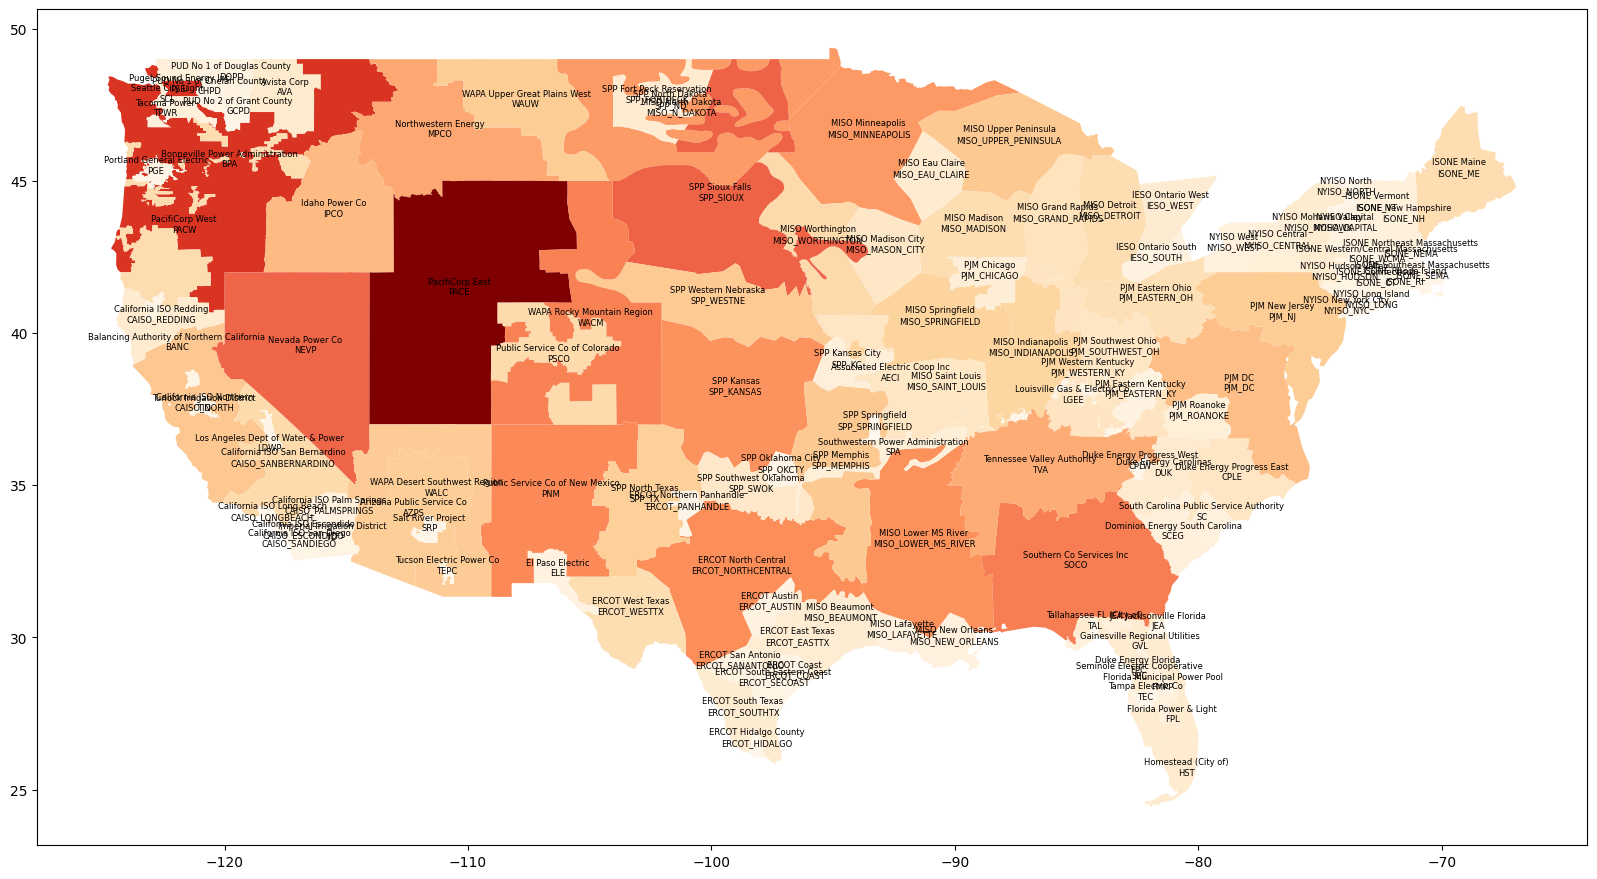

In [33]:
def filter_to_us_regions(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).rename(columns={"name": "country"})
    # filter out those outside of america
    gdf_intersects_us = gpd.sjoin(gdf, world[["country", "geometry"]], how="left", op="intersects").query("country=='United States of America'")
    # extra: anything that goes above 20th parallel or below 50th parallel filtered out
    def US_latitude_filter(geometry):
        # regions that lie between 20th and 50th parallels
        minx, miny, maxx, maxy = geometry.bounds
        return miny >= 20 and maxy <= 50 
    gdf_us = gdf_intersects_us[gdf_intersects_us['geometry'].apply(US_latitude_filter)].copy()
    return gdf_us

def plot_gdf(gdf):
    fig, ax = plt.subplots(figsize=(20, 20))
    gdf.plot(ax=ax, column="area", cmap="OrRd")

    for idx, row in gdf.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row["region_full_name"] + "\n" + row["region"], fontsize=6, ha='center')

    plt.show()

gdf_us = filter_to_us_regions(gdf)
gdf_us["area"] = gdf_us["geometry"].area # will color by area
plot_gdf(gdf_us) 

# Find the regions containing the large cities

In [34]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities')).rename(columns={"name": "city"})
us_cities = gpd.sjoin(cities, world[["geometry", "country"]], how="left", op="intersects").query("country=='United States of America'")
# cwr: cities with regions
cwr = gpd.sjoin(us_cities[["city", "geometry"]], us_regions.drop(columns=["index_right"]), how="left", op="intersects")
cwr[["region","city", "region_full_name"]].reset_index(drop=True)

/tmp/ipykernel_737990/1733259621.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities')).rename(columns={"name": "city"})
/home/robin.elliott/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/robin.elliott/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,region,city,region_full_name
0,CAISO_NORTH,San Francisco,California ISO Northern
1,PSCO,Denver,Public Service Co of Colorado
2,ERCOT_EASTTX,Houston,ERCOT East Texas
3,FPL,Miami,Florida Power & Light
4,SOCO,Atlanta,Southern Co Services Inc
5,PJM_CHICAGO,Chicago,PJM Chicago
6,LDWP,Los Angeles,Los Angeles Dept of Water & Power
7,PJM_DC,"Washington, D.C.",PJM DC
8,NYISO_NYC,New York,NYISO New York City


In [35]:
regions = cwr["region"].to_list()
regions

['CAISO_NORTH',
 'PSCO',
 'ERCOT_EASTTX',
 'FPL',
 'SOCO',
 'PJM_CHICAGO',
 'LDWP',
 'PJM_DC',
 'NYISO_NYC']